In [1]:
import numpy as np
import os
import lightkurve as lk
import pandas as pd

from astroquery.mast import Catalogs

from leo_vetter.stellar import quadratic_ldc
from leo_vetter.main import TCELightCurve
from leo_vetter.plots import plot_summary_with_diff, plot_diffimages
from leo_vetter.thresholds import check_thresholds
from leo_vetter.pixel import pixel_vetting

from tess_stars2px import tess_stars2px_function_entry as ts2px

### Vetting example for TOI-101.01, including difference images

In the first example, we only computed flux-level metrics, but pixel-level metrics are another key component of false positive identification. Signals that are off-target (coming from another star) are one of the most common types of false positives.

Since difference images are the most time-intensive part of this vetting, it is recommended that you only run pixel-level vetting on signals that pass the flux-level vetting tests.

We'll start with the same steps as the previous example (getting the light curve, setting the TCE properties, etc).

In [2]:
tic = 231663901
per = 1.430363 
epo = 1338.885
dur = 0.069

# Download light curve
search_result = lk.search_lightcurve(f"TIC {tic}", mission="TESS", author="TESS-SPOC")
lcs = search_result.download_all()
lc = lcs.stitch()
lc = lc[~np.isnan(lc["flux"]) & (lc["quality"] == 0)]
transit_mask = lc.create_transit_mask(transit_time=epo, period=per, duration=dur)
lc_flat = lc.flatten(mask=transit_mask)

time = np.asarray(lc_flat["time"].value)
raw = np.asarray(lc["flux"].value)
flux = np.asarray(lc_flat["flux"].value)
flux_err = np.asarray(lc_flat["flux_err"].value)

# Get stellar properties
result = Catalogs.query_criteria(catalog="TIC", ID=tic)
star = {}
star["tic"] = tic
for key in ["rad","mass","rho","Teff","logg"]:
    star[key] = float(result[key])
    star["e_"+key] = float(result["e_"+key])

star["u1"], star["u2"] = quadratic_ldc(star["Teff"], star["logg"])

# Pixel vetting also requires the RA and DEC
star["ra"] = float(result["ra"])
star["dec"] = float(result["dec"])

# Load the TCELightCurve class
tlc = TCELightCurve(tic, time, raw, flux, flux_err, per, epo, dur, planetno=1)

# If you ran the previous notebook, the metrics were saved to a file, so we can skip recomputing them here.
save_file = f"{tlc.tic}.{tlc.planetno}.metrics"

if os.path.exists(save_file):
    print("Loading saved metrics from file.")
    metrics = pd.read_csv(save_file, index_col=False)
    tlc.metrics = metrics.to_dict("records")[0]
else:
    tlc.compute_flux_metrics(star, verbose=False)

Loading saved metrics from file.


Difference images need to be made for individual sectors. The star has been observed in several sectors, which we can check with `tess-point`:

In [3]:
_, _, _, all_sectors, all_cams, all_ccds, _, _, _ = ts2px(tic, star["ra"], star["dec"])

print(all_sectors, all_cams, all_ccds)

[ 1 27 67] [2 2 2] [4 3 3]


As of this time of writing, only sectors 1 and 27 have been observed. Let's make difference images for both sectors.

In [4]:
sectors = [1, 27]
tdi, good_sectors, good_pixel_data, good_centroids = pixel_vetting(tlc, star, sectors, tdi_dir=".")

curl "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra=318.736915161395&dec=-55.8717944482812&y=21&x=21&sector=1" --output ./tic231663901_s1.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.9M    0 10.9M    0     0  1806k      0 --:--:--  0:00:06 --:--:-- 2911k


Archive:  ./tic231663901_s1.zip
 extracting: ./tic231663901/tess-s0001-2-4_318.736915_-55.871794_21x21_astrocut.fits  
['./tic231663901/tess-s0001-2-4_318.736915_-55.871794_21x21_astrocut.fits']
./tic231663901/tess-s0001-2-4_318.736915_-55.871794_21x21_astrocut.fits
making difference image for sector 1
curl "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra=318.736915161395&dec=-55.8717944482812&y=21&x=21&sector=27" --output ./tic231663901_s27.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28.5M    0 28.5M    0     0  4104k      0 --:--:--  0:00:07 --:--:-- 7027k


Archive:  ./tic231663901_s27.zip
 extracting: ./tic231663901/tess-s0027-2-3_318.736915_-55.871794_21x21_astrocut.fits  
['./tic231663901/tess-s0027-2-3_318.736915_-55.871794_21x21_astrocut.fits']
./tic231663901/tess-s0027-2-3_318.736915_-55.871794_21x21_astrocut.fits
making difference image for sector 27


The difference images are stored in `good_pixel_data`, and PRF fit results are stored in `good_centroids`. The code also computed a new "offset" metric, which is the average of all offsets based on the star's pixel position and the PRF fit position.

In [5]:
print(f"TIC-{tlc.tic}.{tlc.planetno} is offset by {tlc.metrics['offset']:.3f} pixels")

FA = check_thresholds(tlc.metrics, "FA", verbose=True)
FP = check_thresholds(tlc.metrics, "FP", verbose=True)

if not FA and not FP:
    print(f"TIC-{tlc.tic}.{tlc.planetno} is a planet candidate!")

TIC-231663901.1 is offset by 0.051 pixels
Passed all FA tests
Passed all FP tests
TIC-231663901.1 is a planet candidate!


Plot all difference images for visual inspection:

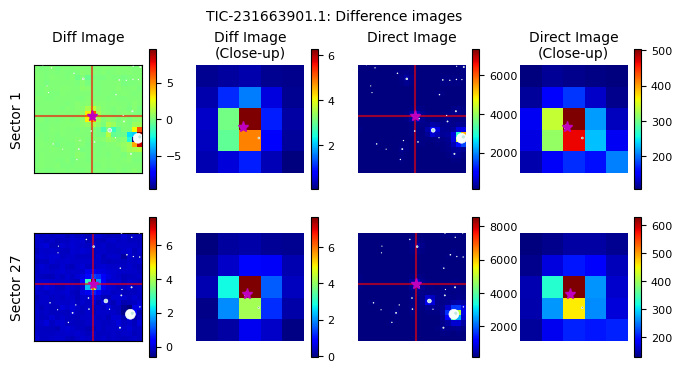

In [6]:
plot_diffimages(tlc.tic, tlc.planetno, tdi, good_sectors, good_pixel_data, save_fig=False)

This looks very nicely on-target in both sectors, as expected for a known planet! We can also include one sector's difference image in summary plots (we'll use the most recent difference image here):

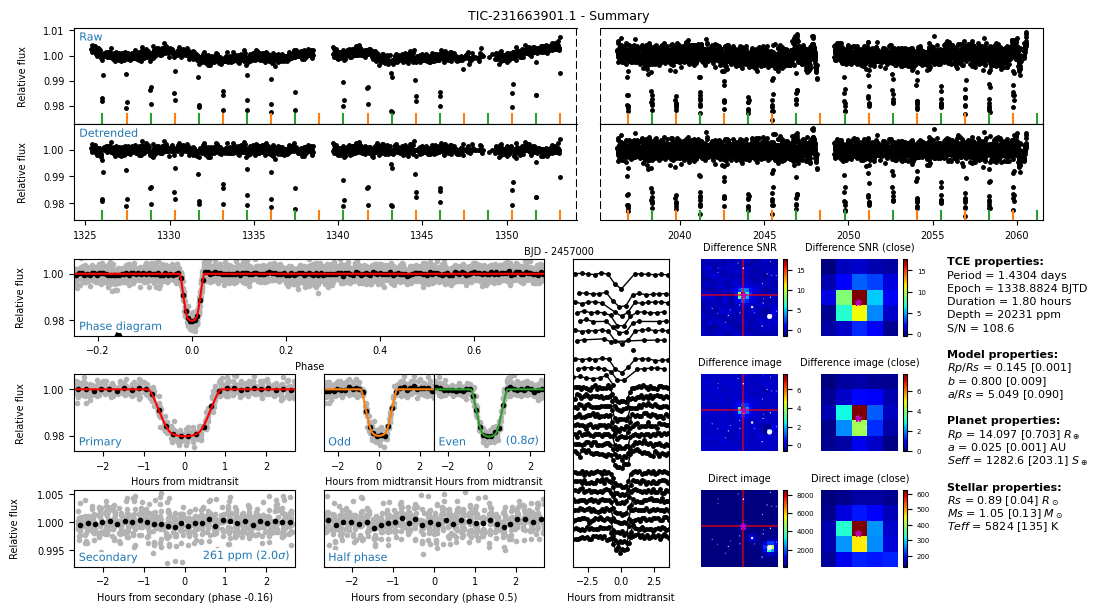

In [7]:
plot_summary_with_diff(tlc, star, tdi, good_pixel_data[-1], save_fig=False)